In [2]:
import os, argparse, time, random
# 1) ───── выбрать GPU до первого «import tensorflow» ─────────
os.environ["CUDA_VISIBLE_DEVICES"] = "1"        # ← меняйте номер по вкусу
# ‑‑‑ если карта одна, строку можно убрать совсем

import numpy as np
import tifffile as tiff
import tensorflow as tf
from tensorflow import keras as K

import settings                          # всё то же, что в train.py
from model   import (                    # используем новые функции
    unet_3d, dice_coef, dice_loss
)
from dataset_tif import TIFPatchDataset

/home/miroslavm/miniforge3/envs/stardist_env/lib/python3.10/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
/home/miroslavm/miniforge3/envs/stardist_env/lib/python3.10/site-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.13.0 and strictly below 2.16.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.12.0 and is not supported. 
Some things might work, some things might not.
If you were to enco

In [8]:
import os, time, argparse
import numpy as np
import matplotlib.pyplot as plt
import tifffile as tiff
import scipy.ndimage as ndi
import tensorflow as tf
from tensorflow import keras as K

import settings
from model import unet_3d, dice_loss, dice_coef, soft_dice_coef
# ───────────────────────────── CLI ────────────────────────────────
parser = argparse.ArgumentParser()
parser.add_argument("--img",  help="Path to 3-D TIFF stack")
parser.add_argument("--mask", help="Path to mask (default <img>_cp_mask.tif)")
parser.add_argument("--thr",  type=float, default=0.950,
                    help="Probability threshold (default 0.5)")
parser.add_argument("--search_thr", action="store_true",
                    help="Grid-search thr∈[0.3..0.7] step 0.05")
parser.add_argument("--gpu", default="1", help="CUDA device (default 1)")
args = parser.parse_args()

usage: ipykernel_launcher.py [-h] [--data_path DATA_PATH] [--epochs EPOCHS]
                             [--saved_model_name SAVED_MODEL_NAME]
                             [--batch_size BATCH_SIZE]
                             [--tile_height TILE_HEIGHT]
                             [--tile_width TILE_WIDTH]
                             [--tile_depth TILE_DEPTH]
                             [--number_input_channels NUMBER_INPUT_CHANNELS]
                             [--number_output_classes NUMBER_OUTPUT_CLASSES]
                             [--validation_split VALIDATION_SPLIT]
                             [--print_model] [--filters FILTERS]
                             [--use_upsampling] [--random_seed RANDOM_SEED]
ipykernel_launcher.py: error: unrecognized arguments: -f /home/miroslavm/.local/share/jupyter/runtime/kernel-784945f9-78ae-4737-b1d2-2ff5a06bb622.json


SystemExit: 2

In [8]:
input_shape = (
    settings.TILE_HEIGHT,
    settings.TILE_WIDTH,
    settings.TILE_DEPTH,               # == 64
    settings.NUMBER_INPUT_CHANNELS     # == 1
)

model = unet_3d(
    input_dim=input_shape,
    filters=settings.FILTERS,                  # 16
    number_output_classes=settings.NUMBER_OUTPUT_CLASSES,
    use_upsampling=settings.USE_UPSAMPLING     # False
)

ckpt_path = "checkpoints/unet_res_hela_best"   # как в train.py
model.load_weights(ckpt_path)
print("[info] weights loaded from", ckpt_path)

NameError: name 'unet_3d' is not defined

In [10]:
if args.img is None:
    #test_dir = "/storage01/miroslavm/3d_segmentation_models/data_rat/test"
    test_dir ='/NAS/mmaiurov/Datasets/Hela_MRC/test'
    tifs = [f for f in os.listdir(test_dir) if f.endswith(".tif") and "_cp_mask" not in f]
    if not tifs:
        raise FileNotFoundError("No .tif in test directory")
    args.img = os.path.join(test_dir, tifs[0])
    print(f"[info] --img not set, using {args.img}")

img_path  = args.img
mask_path = args.mask or os.path.splitext(img_path)[0] + "_cp_mask.tif"
assert os.path.exists(mask_path), f"mask {mask_path} not found"


[info] --img not set, using /NAS/mmaiurov/Datasets/Hela_MRC/test/20221107_HeLa_MRC_24hLN_DLS Acquire 2_007_Target_Lng_z00_ch00.tif


In [11]:
def preprocess(vol):
    """vol (D,H,W) or (H,W,D) ➜ (H,W,64) float32 z-norm"""
    if vol.shape[0] == settings.TIF_DEPTH:
        vol = np.transpose(vol, (1,2,0))          # (H,W,D)
    pad_d = (16 - vol.shape[2] % 16) % 16
    if pad_d:
        vol = np.pad(vol, ((0,0),(0,0),(0,pad_d)), mode="reflect")
    v = vol.astype(np.float32)
    return (v - v.mean()) / (v.std() + 1e-6)

raw_img  = tiff.imread(img_path)
raw_mask = tiff.imread(mask_path)
vol = preprocess(raw_img)             # (H,W,64)
gt  = (preprocess(raw_mask) > 0).astype(np.float32)


In [12]:
# ───────────────── choose GPU & load model ───────────────────────
os.environ["CUDA_VISIBLE_DEVICES"] = args.gpu
model = K.models.load_model("checkpoints/unet_hela_best",
    custom_objects={"dice_loss": dice_loss,
                    "dice_coef": dice_coef,
                    "soft_dice_coef": soft_dice_coef},
    compile=False)

In [ ]:
# ───────────────── helper: Tukey weight window ───────────────────
def make_weight(tile=(256,256,64), edge=32):
    from scipy.signal.windows import tukey
    h,w,d = tile
    w_h = tukey(h, 2*edge/h);  w_w = tukey(w, 2*edge/w);  w_d = tukey(d, 0.4)
    return (np.outer(w_h, w_w).reshape(h,w,1)*w_d.reshape(1,1,d)).astype(np.float32)
WEIGHT = make_weight()

# ───────────────── sliding-window prediction ─────────────────────
def predict_full(img, net, tile=(256,256,64), stride=(128,128,32)):
    H,W,D = img.shape; th,tw,td = tile; sh,sw,sd = stride
    out = np.zeros((H,W,D), np.float32); norm = np.zeros_like(out)
    y0s = list(range(0, H-th, sh)) + [H-th]
    x0s = list(range(0, W-tw, sw)) + [W-tw]
    z0s = list(range(0, D-td, sd)) + [D-td]
    for z0 in z0s:
        for y0 in y0s:
            for x0 in x0s:
                patch = img[y0:y0+th, x0:x0+tw, z0:z0+td][None,...,None]
                pred  = net.predict(patch, verbose=0)[0,...,0]
                out [y0:y0+th, x0:x0+tw, z0:z0+td] += pred * WEIGHT
                norm[y0:y0+th, x0:x0+tw, z0:z0+td] += WEIGHT
    return np.clip(out / np.maximum(norm, 1e-6), 0, 1)

start = time.time()
pred_prob = predict_full(vol, model)
print(f"Inference {1000*(time.time()-start):.1f} ms")

Dice@0.50 = 0.831


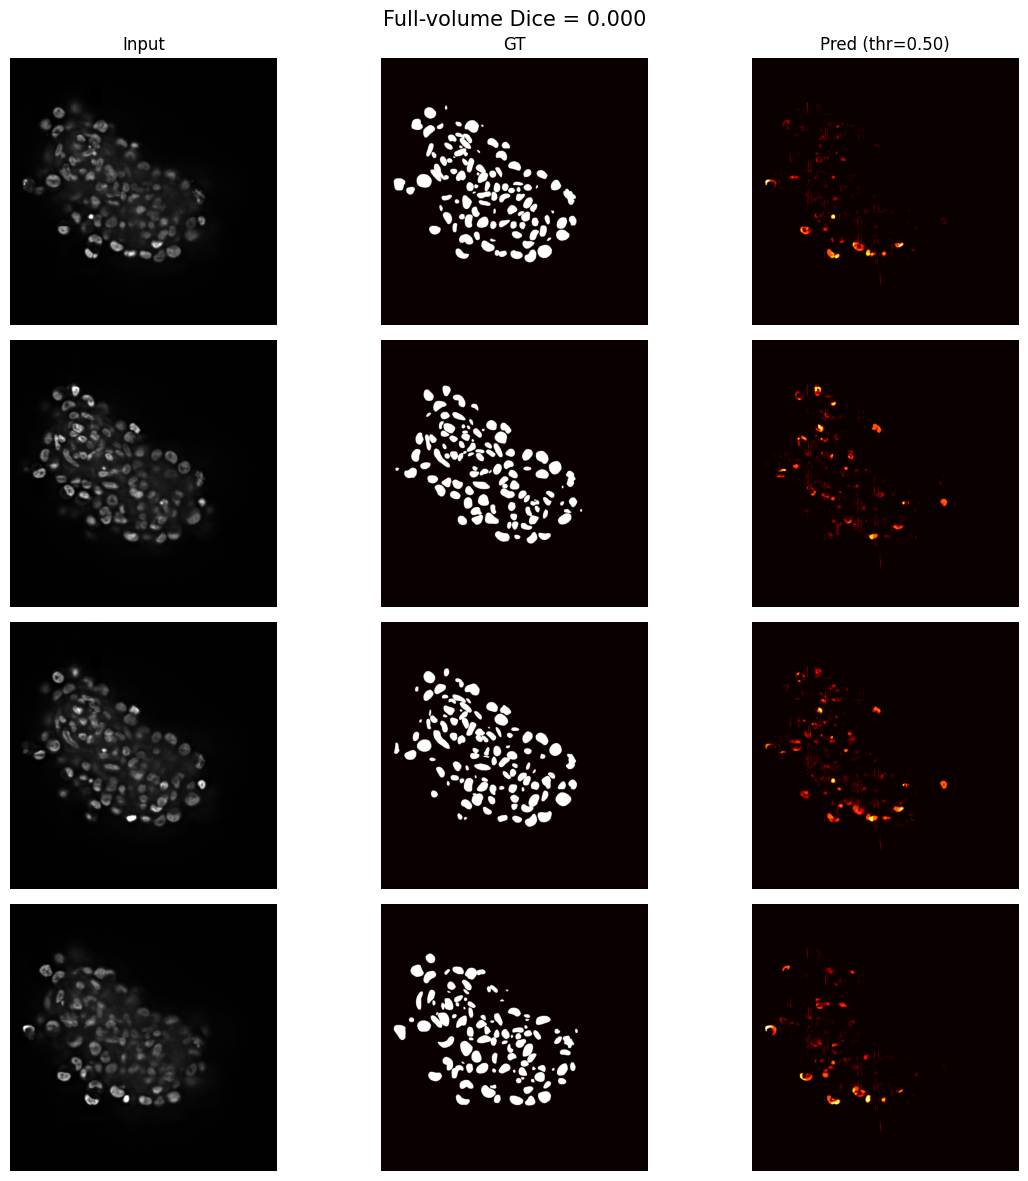

In [60]:
# ───────────────── визуализация 4 лучших срезов ──────────────────
z_scores = gt.sum((0,1))
top_z = z_scores.argsort()[-4:][::-1]

fig, ax = plt.subplots(len(top_z), 3, figsize=(12, 3*len(top_z)))
titles = ['Input','GT',f'Pred (thr={best_thr:.2f})']
for r,z in enumerate(top_z):
    ax[r,0].imshow(vol[:,:,z],        cmap='gray')
    ax[r,1].imshow(gt[:,:,z],         cmap='hot')
    ax[r,2].imshow(pred_prob[:,:,z],  cmap='hot')
    for c in range(3):
        ax[r,c].axis('off')
        if r==0: ax[r,c].set_title(titles[c], fontsize=12)
fig.suptitle(f'Full-volume Dice = {dice_val:.3f}', fontsize=15)
plt.tight_layout(); plt.show()

In [9]:
import os, time, argparse, numpy as np, tifffile as tiff
import matplotlib.pyplot as plt, tensorflow as tf
from tensorflow import keras as K
import settings
from model import dice_loss, dice_coef, soft_dice_coef, unet_3d

# ---------- CLI ----------
parser = argparse.ArgumentParser()
parser.add_argument("--img")
parser.add_argument("--mask")
parser.add_argument("--thr",  type=float, default=0.50)
parser.add_argument("--search_thr", action="store_true")
parser.add_argument("--gpu", default="1")
args = parser.parse_args()

# ---------- choose GPU ----------
os.environ["CUDA_VISIBLE_DEVICES"] = args.gpu

#---------- load SavedModel ----------
ckpt_path = "checkpoints/unet_res_hela_best"          # директория‑чекпойнт
model = K.models.load_model(
    ckpt_path,
    custom_objects={"dice_loss": dice_loss,
                    "dice_coef": dice_coef,
                    "soft_dice_coef": soft_dice_coef},
    compile=False)
print("[info] model loaded from", ckpt_path)





# ---------- helper constants ----------
TILE   = (settings.TILE_HEIGHT, settings.TILE_WIDTH, settings.TILE_DEPTH)   # (256,256,48)
STRIDE = (TILE[0]//2, TILE[1]//2, TILE[2]//2)                               # (128,128,24)

# ---------- IO ----------
if args.img is None:
    test_dir = "/NAS/mmaiurov/Datasets/Hela_MRC/test"
    args.img = next(p for p in os.listdir(test_dir) if p.endswith(".tif") and "_cp_mask" not in p)
    args.img = os.path.join(test_dir, args.img)
    print(f"[info] --img not set, using {args.img}")

img_path  = args.img
mask_path = args.mask or os.path.splitext(img_path)[0] + "_cp_mask.tif"
assert os.path.exists(mask_path), f"mask {mask_path} not found"


usage: ipykernel_launcher.py [-h] [--data_path DATA_PATH] [--epochs EPOCHS]
                             [--saved_model_name SAVED_MODEL_NAME]
                             [--batch_size BATCH_SIZE]
                             [--tile_height TILE_HEIGHT]
                             [--tile_width TILE_WIDTH]
                             [--tile_depth TILE_DEPTH]
                             [--number_input_channels NUMBER_INPUT_CHANNELS]
                             [--number_output_classes NUMBER_OUTPUT_CLASSES]
                             [--validation_split VALIDATION_SPLIT]
                             [--print_model] [--filters FILTERS]
                             [--use_upsampling] [--random_seed RANDOM_SEED]
ipykernel_launcher.py: error: unrecognized arguments: -f /home/miroslavm/.local/share/jupyter/runtime/kernel-784945f9-78ae-4737-b1d2-2ff5a06bb622.json


SystemExit: 2

In [1]:
import os, time, argparse, numpy as np, tifffile as tiff
import matplotlib.pyplot as plt, tensorflow as tf
from tensorflow import keras as K
import settings

from model_classic import dice_loss, dice_coef, soft_dice_coef, unet_3d
os.environ["CUDA_VISIBLE_DEVICES"] = args.gpu
args = parser.parse_args(args=[])
# ---------- build model ----------
input_shape = (
    settings.TILE_HEIGHT,
    settings.TILE_WIDTH,
    settings.TILE_DEPTH,
    settings.NUMBER_INPUT_CHANNELS
)

model = unet_3d(
    input_dim=input_shape,
    filters=settings.FILTERS,
    number_output_classes=settings.NUMBER_OUTPUT_CLASSES,
    use_upsampling=settings.USE_UPSAMPLING
)

# ---------- load weights ----------
ckpt_path = "checkpoints/unet_drres_hela/unet_DRres_hela_best"
model.load_weights(ckpt_path)
print("[info] weights loaded from", ckpt_path)


2025-07-18 10:38:32.203754: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-18 10:38:32.239192: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 AVX_VNNI AMX_TILE AMX_INT8 AMX_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-07-18 10:38:32.738489: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
usage: ipykernel_launcher.py [-h] [--data_path DATA_PATH] [--epochs EPOCHS]
                             [--saved_model_name SAVED_MODEL_NAME]
                             [--batch_size BATCH_SIZE]
    

SystemExit: 2

/home/miroslavm/.local/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3587: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


2025-07-18 09:23:29.685512: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8907


Inference 26821.0 ms


In [61]:
import os, sys, time, argparse
import numpy as np
import tifffile as tiff
from scipy.signal.windows import tukey
from scipy.sparse import csr_matrix
from skimage.measure import label

# ───────────── argparse ─────────────
def get_args() -> argparse.Namespace:
    parser = argparse.ArgumentParser(description="UNet‑3D inference")
    # делаем флаги НЕобязательными, чтобы в ноутбуке проще было задавать вручную
    parser.add_argument("--img_path",  help="raw .tif volume")
    parser.add_argument("--mask_path", help="GT mask .tif")
    parser.add_argument("--ckpt_path", default="checkpoints/unet_drres_hela/unet_DRres_hela_last",
                        help="checkpoint path (без .index/.data‑*)")
    parser.add_argument("--gpu",       default="0",
                        help="GPU id, -1 → CPU")
    parser.add_argument("--thr",       type=float, default=0.5,
                        help="fixed threshold for binarisation")
    parser.add_argument("--search_thr", action="store_true",
                        help="grid‑search best threshold on GT")

    # В ноутбуке игнорируем посторонние kernel‑аргументы
    if "ipykernel" in sys.modules:
        return parser.parse_args(args=[])     # ← пустой argv
    # В консоли – parse_known_args(), чтобы не упасть, если чужие флаги
    return parser.parse_known_args()[0]

args = get_args()

In [62]:
# ───────────── НАСТРОЙКИ ДЛЯ НОУТБУКА ─────────────
# Задайте свои пути один раз здесь, если запускаете внутри Jupyter
if "ipykernel" in sys.modules:
    args.img_path  = args.img_path  or "NAS/mmaiurov/Datasets/Hela_MRC/test/20221107_HeLa_MRC_24hLN_DLS Acquire 2_007_Target_Lng_z00_ch00.tif"   # <– ваш файл
    args.mask_path = args.mask_path or "/NAS/mmaiurov/Datasets/Hela_MRC/test/20221107_HeLa_MRC_24hLN_DLS Acquire 2_007_Target_Lng_z00_ch00_cp_mask.tif"    # <– ваш файл

# Проверка: если путей всё‑таки нет – даём понятную ошибку
if not args.img_path or not args.mask_path:
    raise RuntimeError(
        "Не задан --img_path / --mask_path. "
        "Либо передайте флаги в консоли, либо пропишите значения в блоке «НАСТРОЙКИ ДЛЯ НОУТБУКА»."
    )

# ───────────── окружение GPU/CPU ─────────────
if args.gpu == "-1":
    os.environ["CUDA_VISIBLE_DEVICES"] = ""
else:
    os.environ["CUDA_VISIBLE_DEVICES"] = args.gpu

In [63]:
import tensorflow as tf                     # noqa: E402
from tensorflow import keras as K            # noqa: E402
import sys
sys.argv = sys.argv[:1]      # оставить только имя скрипта

import settings                               # noqa: E402 (ваш модуль)
from model_DR import (                 # noqa: E402
    dice_loss, dice_coef, soft_dice_coef, unet_3d
)

input_shape = (
    settings.TILE_HEIGHT,
    settings.TILE_WIDTH,
    settings.TILE_DEPTH,
    settings.NUMBER_INPUT_CHANNELS,
)

model = unet_3d(
    input_dim=input_shape,
    filters=settings.FILTERS,
    number_output_classes=settings.NUMBER_OUTPUT_CLASSES,
    use_upsampling=settings.USE_UPSAMPLING,
)
model.load_weights(args.ckpt_path)
print(f"[info] weights loaded from {args.ckpt_path}")

# ───────────── константы слай‑виндоу ─────────────
TILE   = (settings.TILE_HEIGHT, settings.TILE_WIDTH, settings.TILE_DEPTH)
STRIDE = (TILE[0]//2, TILE[1]//2, TILE[2]//2)

[info] weights loaded from checkpoints/unet_drres_hela/unet_DRres_hela_last


In [49]:
img_path   = "/NAS/mmaiurov/Datasets/Hela_MRC/test/20221107_HeLa_MRC_24hLN_DLS Acquire 2_007_Target_Lng_z00_ch00.tif"
mask_path  = "/NAS/mmaiurov/Datasets/Hela_MRC/test/20221107_HeLa_MRC_24hLN_DLS Acquire 2_007_Target_Lng_z00_ch00_cp_mask.tif"
args.ckpt_path  = "checkpoints/unet_drres_hela/unet_DRres_hela_best"

In [57]:
# ---------- preprocessing ----------
def preprocess(vol):
    """
    Приводит к (H,W,D) с D = settings.TILE_DEPTH,
    float32, z‑нормировка.
    """
    vol = np.squeeze(vol)                       # снимаем лишние оси
    # --- переносим ось глубины в конец ---
    depth_axis = np.argmin(vol.shape)           # обычно Z самая короткая (≈64)
    if depth_axis != 2:
        vol = np.moveaxis(vol, depth_axis, 2)   # теперь (H,W,D)

    # --- паддинг глубины до кратной 16 ---
    pad_d = (settings.TILE_DEPTH - vol.shape[2] % settings.TILE_DEPTH) % settings.TILE_DEPTH
    if pad_d:
        vol = np.pad(vol, ((0,0), (0,0), (0,pad_d)), mode="reflect")

    v = vol.astype(np.float32)
    return (v - v.mean()) / (v.std() + 1e-6)

raw_img  = tiff.imread(img_path)
raw_mask = tiff.imread(mask_path)
vol = preprocess(raw_img)
gt  = (preprocess(raw_mask) > 0).astype(np.float32)

In [58]:
from scipy.signal.windows import tukey
def make_weight(tile=TILE, edge=32):
    h,w,d = tile
    w_h = tukey(h, 2*edge/h);  w_w = tukey(w, 2*edge/w);  w_d = tukey(d, 0.4)
    return (np.outer(w_h, w_w).reshape(h,w,1)*w_d.reshape(1,1,d)).astype(np.float32)
WEIGHT = make_weight()

# ---------- sliding‑window prediction ----------
def predict_full(img, net, tile=TILE, stride=STRIDE):
    H,W,D = img.shape; th,tw,td = tile; sh,sw,sd = stride
    out  = np.zeros((H,W,D), np.float32)
    norm = np.zeros_like(out)
    for z0 in list(range(0, D-td, sd)) + [D-td]:
        for y0 in list(range(0, H-th, sh)) + [H-th]:
            for x0 in list(range(0, W-tw, sw)) + [W-tw]:
                patch = img[y0:y0+th, x0:x0+tw, z0:z0+td][None, ..., None]
                pred  = net.predict(patch, verbose=0)[0, ..., 0]
                out [y0:y0+th, x0:x0+tw, z0:z0+td] += pred * WEIGHT
                norm[y0:y0+th, x0:x0+tw, z0:z0+td] += WEIGHT
    return np.clip(out / np.maximum(norm, 1e-6), 0, 1)

start = time.time()
pred_prob = predict_full(vol, model)
print(f"Inference {1000*(time.time()-start):.1f} ms")

Inference 32397.9 ms


In [59]:
# ───────────────── Dice / threshold search ───────────────────────
def full_dice(th):
    bin_pred = pred_prob > th
    return 2*np.sum(gt*bin_pred) / (gt.sum()+bin_pred.sum()+1e-5)

best_thr = args.thr
if args.search_thr:
    th_grid = np.linspace(0.30, 0.70, 9)
    dices = [full_dice(t) for t in th_grid]
    best_thr = th_grid[int(np.argmax(dices))]
    print("grid-search thr→", best_thr)

dice_val = full_dice(best_thr)
print(f"Dice@{best_thr:.2f} = {dice_val:.3f}")

Dice@0.50 = 0.000


In [47]:
from scipy.sparse import csr_matrix
from skimage.measure import label
def dice_full(gt, pred_prob, threshold=0.5, match_iou_thr=0.5):
    """
    Computes instance-level F1-score, precision, recall based on IoU matching.

    Returns:
        f1: instance-level Dice/F1-score
        precision: TP / (TP + FP)
        recall:    TP / (TP + FN)
        tp, fp, fn: counts
    """
    pred_mask = pred_prob > threshold
    gt_label = label(gt)
    pred_label = label(pred_mask)

    gt_ids = np.unique(gt_label)
    pred_ids = np.unique(pred_label)
    gt_ids = gt_ids[gt_ids != 0]
    pred_ids = pred_ids[pred_ids != 0]

    if len(gt_ids) == 0 and len(pred_ids) == 0:
        return 1.0, 1.0, 1.0, 0, 0, 0
    if len(gt_ids) == 0:
        return 0.0, 0.0, 0.0, 0, len(pred_ids), 0
    if len(pred_ids) == 0:
        return 0.0, 0.0, 0.0, 0, 0, len(gt_ids)

    gt_flat = gt_label.ravel()
    pred_flat = pred_label.ravel()

    conf = csr_matrix((np.ones_like(gt_flat), (gt_flat, pred_flat)),
                      shape=(gt_label.max()+1, pred_label.max()+1),
                      dtype=np.uint32).toarray()
    conf = conf[1:, 1:]  # remove background

    gt_areas = conf.sum(axis=1, keepdims=True)
    pred_areas = conf.sum(axis=0, keepdims=True)
    union = gt_areas + pred_areas - conf

    iou = conf / (union + 1e-8)

    matches = iou > match_iou_thr

    tp = np.sum(matches.any(axis=1))  # GT matched
    fp = np.sum(~matches.any(axis=0)) # Pred unmatched
    fn = np.sum(~matches.any(axis=1)) # GT unmatched

    precision = tp / (tp + fp + 1e-8)
    recall    = tp / (tp + fn + 1e-8)
    f1        = 2 * precision * recall / (precision + recall + 1e-8)

    return f1, precision, recall, tp, fp, fn

In [48]:
f1, precision, recall, tp, fp, fn = dice_full(gt, pred_prob, threshold=best_thr)
print(f"F1@{best_thr:.2f} = {f1:.3f} | Precision: {precision:.3f}  Recall: {recall:.3f} | TP: {tp}  FP: {fp}  FN: {fn}")

F1@0.50 = 0.000 | Precision: 0.000  Recall: 0.000 | TP: 0  FP: 0  FN: 106
